In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
df_w = load_data(file_name="df_weekly_685.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="dict_weekly_685.pkl", file_path=WORK_DATA_DIR)

# Model features

In [5]:
# select model features
cols = [
    'vixo',
     'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
    'ff_HML',
     'termspread',
     'pc_ratio',
     'aaii_Bullish',
    'sp_close',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_close_lag3',
    'sp_agg1',
    # 'goog_sent',
    # 'fears35'
]

In [6]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

# Cross corr

In [7]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["sp_cols"]],
              "sp_close_lead1",
              show_plot=False)

[['vixo', 7, 0.083],
 ['naaim_ind', 8, 0.153],
 ['ff_M_RF', 0, 0.181],
 ['ff_SMB', 9, 0.07],
 ['ff_RMW', 0, 0.07],
 ['ff_CMA', 1, 0.085],
 ['ff_HML', 5, 0.102],
 ['termspread', 1, 0.067],
 ['pc_ratio', 7, 0.081],
 ['aaii_Bullish', 6, 0.088]]

In [8]:
df_ws = shift_var_relative_to_df(df_ws, shift_var=["ff_CMA", 
                                                   "vixo",
                                                   "naaim_ind",
                                                   "ff_HML"
                                                   # "naaim_ind",
                                                   # "aaii_Bullish"
                                                  ], no_lags=[
    1,
    7,
    8,
    5
    # 8,
    # 6
])

# Multi corr

,VIF,corr_sp_close_lead1
ff_M_RF,1.711253,-0.181186
naaim_ind,1.039740,-0.152973
sp_close,1.682413,-0.147267
ff_CMA,1.055356,-0.083382
vixo,1.022153,-0.082647
ff_SMB,1.139950,-0.061756
sp_close_lag2,2.187366,-0.009829
sp_close_lag1,2.286087,0.013489
sp_close_lag3,1.809392,0.018549
termspread,1.043116,0.022298


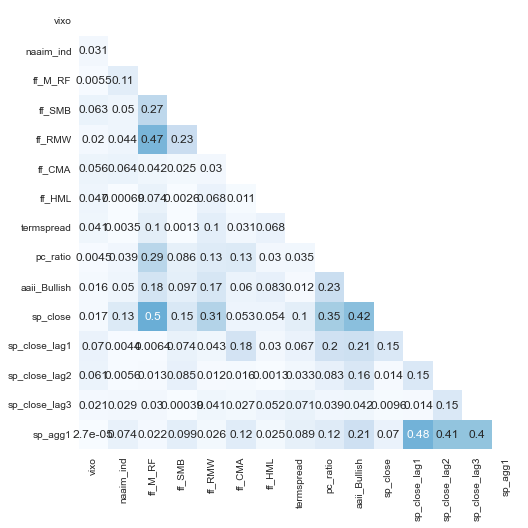

In [9]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=.5,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# tts & standard scaling

In [10]:
df_train = df_ws.copy()

In [11]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, add_const=False, random_split=False, test_size=.2)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler_x = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)

# Model

In [14]:
lgb_model = lgb.LGBMRegressor(random_state=random_state)

lgb_model.fit(X_train,
              y_train)

LGBMRegressor(random_state=101)

# Model eval

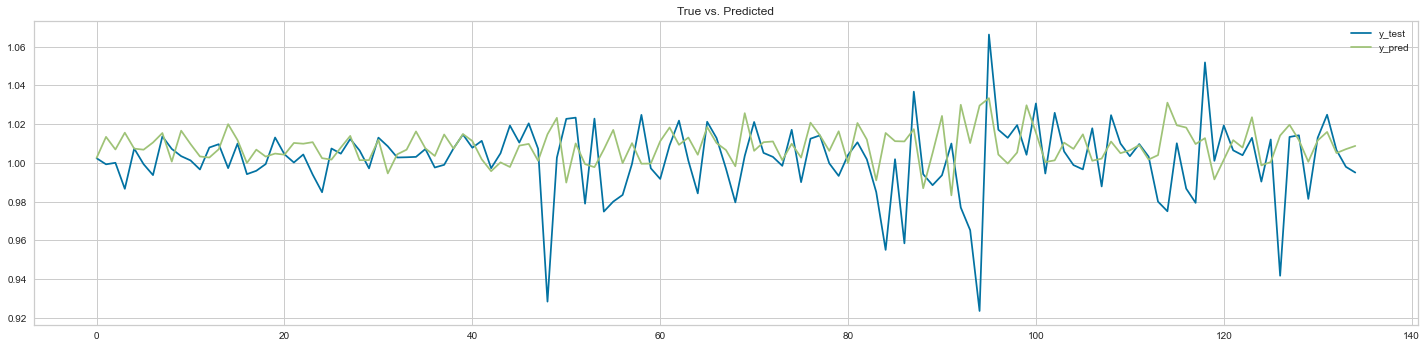

Validation Scores
mean squared error: 0.00048289
mean absolute error: 0.01465078
R2: -0.3858


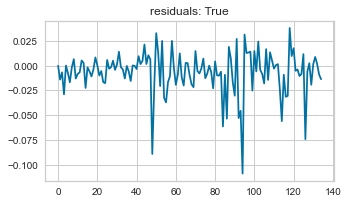

Stationarity Test Results
P-Values: 9.87470979573214e-21
Test-stats: -11.353274349642946
Time series is stationary: True


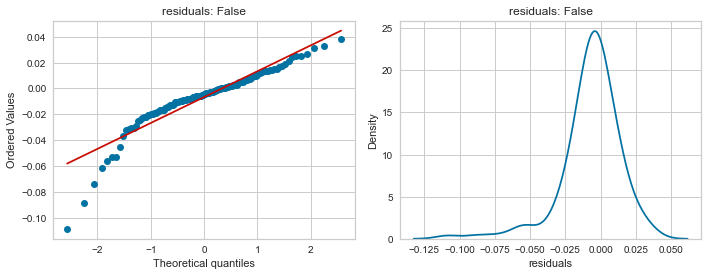

Normality Test Results
P-Values: 9.557689863995018e-14
Test-stats: 59.95769050016012
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


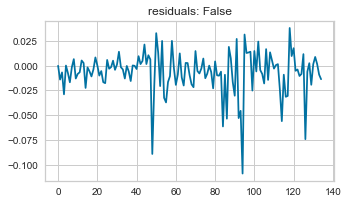

Test for Heteroskedasticity
Test p-value: 0.45951888044828637
Heteroskedasticity is present: False


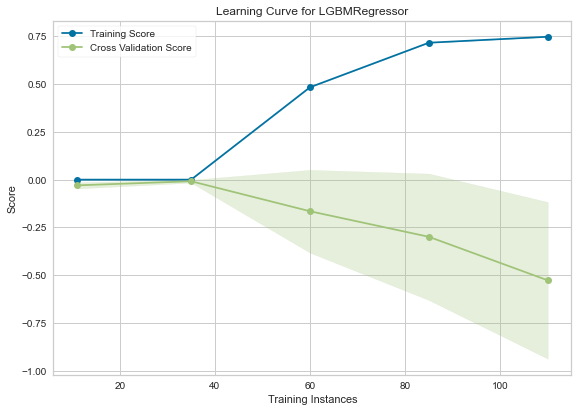

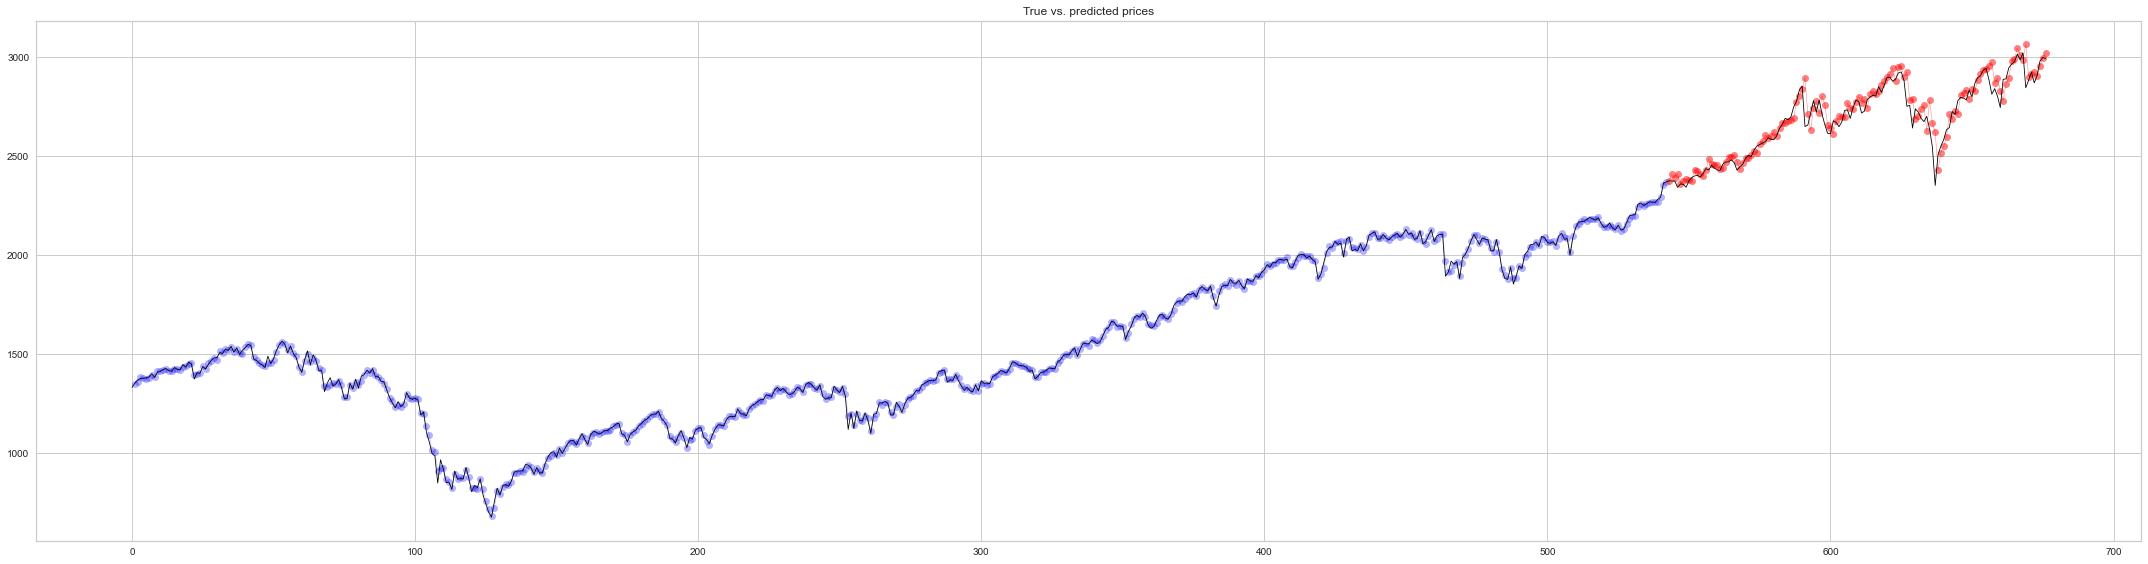

Validation Scores Test Data
mean squared error: 3627.1190932144204
mean absolute error: 39.704076321669504
mean absolute error %: 2.264767884410501


In [17]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=lgb_model,
                           data_dict=data_dict)
lgb_eval.get_model_performance()
lgb_eval.analyse_resids(print_results=True)
lgb_eval.plot_learning_curve(n_splits=4, scoring="r2")
lgb_eval.plot_results_on_price_scale(df_w,
                                     df_ws)

In [18]:
# Parameter tuning

In [ ]:
import optuna.integration.lightgbm as lgb_opt

d_train = lgb_opt.Dataset(X_train, label=y_train)
d_test = lgb_opt.Dataset(X_test, label=y_test)

params = {
    'metric' : 'mean_squared_error'
}

tuner = lgb_opt.LightGBMTuner(
    
    time_budget=2000,
    train_set=d_train,
    valid_sets=d_test,
    params=params,
    show_progress_bar=True
)

tuner.run()

list1 = []
list2 = []
for item in tuner.best_params:
    
    list1.append(item)
    list2.append(tuner.best_params[item])
    
best_params = dict(zip(list1, list2))